In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate ,BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import seaborn as sns

In [2]:
def load_images_from_directory(directory, target_size):
    images = []
    for filename in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [3]:
def load_masks_from_directory(directory, target_size):
    masks = []
    for filename in sorted(os.listdir(directory)):
        mask_path = os.path.join(directory, filename)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")  # Load as grayscale
        mask_array = img_to_array(mask)
        masks.append(mask_array)
    return np.array(masks)

In [4]:
image_dir = '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'
mask_dir = '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks'
target_size = (128, 128)

In [5]:
images = load_images_from_directory(image_dir, target_size) / 255.0
masks = load_masks_from_directory(mask_dir, target_size) / 255.0

In [6]:
def display_sample(images, masks, index=0,num_sample=1):

    for i in range(num_sample):
        plt.figure(figsize=(5, 2.5))

        sample_index = index + i
        
        plt.subplot(1, 2, 1)
        plt.title("Sample Image")
        plt.imshow(images[sample_index])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Sample Mask")
        plt.imshow(masks[sample_index].squeeze(), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

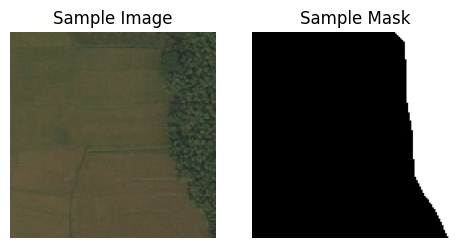

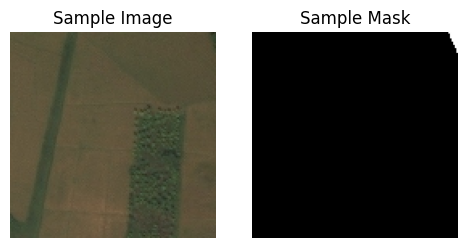

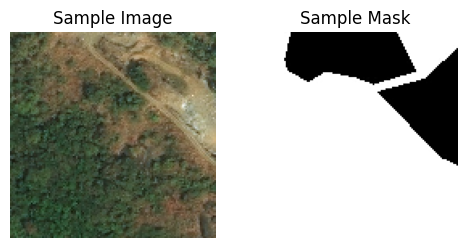

In [7]:
display_sample(images,masks,index=0,num_sample=3)

In [8]:
x_train,x_test,y_train,y_test = train_test_split(images,masks,test_size=0.2,random_state=42)

In [9]:
x_train,x_val,y_train,y_val = train_test_split(images,masks,test_size=0.2,random_state=42)

In [10]:
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    #vertical_flip=True,
    #brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [11]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [12]:
seed = 42 
train_image_generator = image_datagen.flow(x_train, batch_size=16, seed=seed)
train_mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)
val_image_generator = image_datagen.flow(x_val, batch_size=16, seed=seed)
val_mask_generator = mask_datagen.flow(y_val, batch_size=16, seed=seed)

In [13]:
def combine_generators(image_generator, mask_generator):
    for img, mask in zip(image_generator, mask_generator):
        yield img, mask

In [14]:
batch_size = 16
steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

train_generator = combine_generators(train_image_generator, train_mask_generator)
val_generator = combine_generators(val_image_generator, val_mask_generator)

In [15]:
def DeepLabV3Plus(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    # Backbone - Pre-trained ResNet50 (without top layers)
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    
    # ASPP
    x = base_model.get_layer("conv4_block6_out").output  
    
    aspp1 = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(x)
    aspp1 = layers.BatchNormalization()(aspp1)
    
    aspp2 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(x)
    aspp2 = layers.BatchNormalization()(aspp2)
    
    aspp3 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(x)
    aspp3 = layers.BatchNormalization()(aspp3)
    
    aspp4 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(x)
    aspp4 = layers.BatchNormalization()(aspp4)
    
    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
    avg_pool = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(avg_pool)
    avg_pool = layers.BatchNormalization()(avg_pool)
    
    # Fix: Use dynamic resizing
    avg_pool = layers.UpSampling2D(
        size=(x.shape[1] // avg_pool.shape[1], x.shape[2] // avg_pool.shape[2]),
        interpolation="bilinear"
    )(avg_pool)
    
    # Concatenate ASPP features
    aspp = layers.Concatenate()([aspp1, aspp2, aspp3, aspp4, avg_pool])
    aspp = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(aspp)
    aspp = layers.BatchNormalization()(aspp)
    aspp = layers.Dropout(0.5)(aspp)
    
    # Decoder
    low_level_features = base_model.get_layer("conv2_block3_out").output
    low_level_features = layers.Conv2D(48, (1, 1), padding="same", activation="relu")(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)
    
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(aspp)
    x = layers.Concatenate()([x, low_level_features])
    
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    
    outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(x)
    
    model = models.Model(inputs, outputs, name="DeepLabV3Plus")
    
    return model

In [16]:
input_shape = (128, 128, 3)
model = DeepLabV3Plus(input_shape=input_shape, num_classes=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.summary()

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=35,
    validation_data=val_generator,
    validation_steps=validation_steps,
)

Epoch 1/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 299ms/step - accuracy: 0.7203 - loss: 0.5591 - mean_io_u: 0.2253 - val_accuracy: 0.4038 - val_loss: 6.7398 - val_mean_io_u: 0.2057
Epoch 2/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - accuracy: 0.7828 - loss: 0.4420 - mean_io_u: 0.2284 - val_accuracy: 0.3807 - val_loss: 4.5292 - val_mean_io_u: 0.2073
Epoch 3/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - accuracy: 0.7929 - loss: 0.4268 - mean_io_u: 0.2231 - val_accuracy: 0.3800 - val_loss: 4.9886 - val_mean_io_u: 0.2066
Epoch 4/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.7953 - loss: 0.4269 - mean_io_u: 0.2214 - val_accuracy: 0.6439 - val_loss: 0.8130 - val_mean_io_u: 0.2061
Epoch 5/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.7973 - loss: 0.4203 - mean_io_u: 0.2260 - val_accuracy: 0.7954 - val_loss: 0.4346 - val_mean_io_u: 0.2063
Epoch 6/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.7937 - loss: 0.4314 - mean_io_u: 0.2251 - val_accuracy:

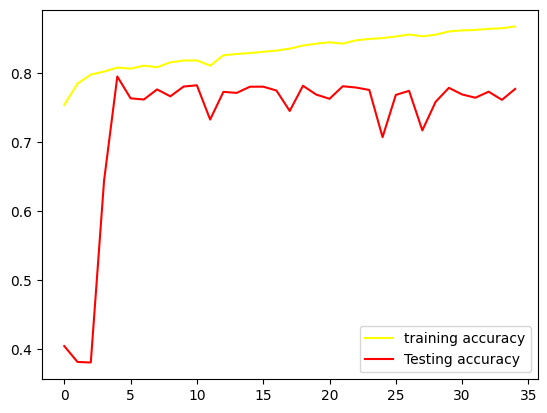

In [28]:
plt.plot(history.history['accuracy'],color='yellow',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

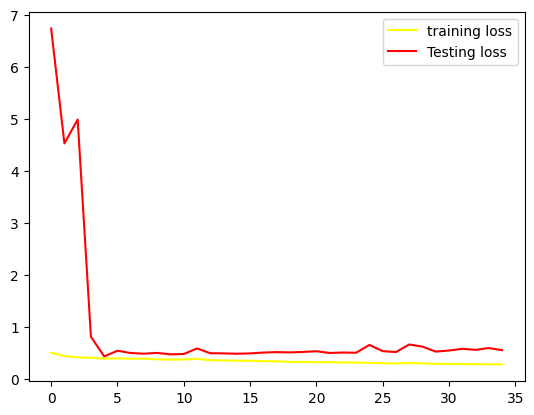

In [29]:
plt.plot(history.history['loss'],color='yellow',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

In [18]:
test_loss, test_accuracy, test_miou = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test mIoU: {test_miou}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.8258 - loss: 0.4528 - mean_io_u: 0.1978
Test Loss: 0.4617990553379059, Test Accuracy: 0.8226773738861084, Test mIoU: 0.20089229941368103


In [19]:
predicted_masks = model.predict(x_test)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold for binary masks

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = (y_test > 0.5).astype(np.uint8).flatten()  # Threshold and flatten
y_pred = predicted_masks.flatten()  

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Background", "Foreground"]))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

  Background       0.78      0.80      0.79   6616033
  Foreground       0.86      0.85      0.86  10128415

    accuracy                           0.83  16744448
   macro avg       0.82      0.82      0.82  16744448
weighted avg       0.83      0.83      0.83  16744448

Confusion Matrix:
[[5266233 1349800]
 [1497862 8630553]]


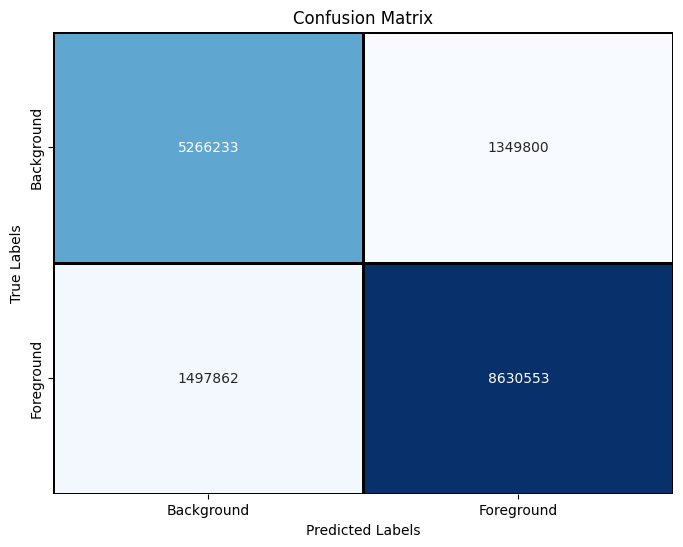

In [23]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        linewidths=1,
        linecolor="black"
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


class_names = ["Background", "Foreground"]
plot_confusion_matrix(cm, class_names)


In [24]:
import time
import numpy as np

def measure_inference_time(model, x_test, num_samples):

    total_time = 0.0
    test_subset = x_test[:num_samples]

    for i in range(num_samples):
     
        start_time = time.time()

      
        _ = model.predict(np.expand_dims(test_subset[i], axis=0))

       
        end_time = time.time()

       
        total_time += (end_time - start_time)

    avg_time_per_image = (total_time / num_samples) * 1000  # Convert to milliseconds
    return avg_time_per_image

num_samples = 10 
avg_inference_time = measure_inference_time(model, x_test, num_samples)
print(f"Average inference time per image: {avg_inference_time:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Average inference time per image: 285.72 ms


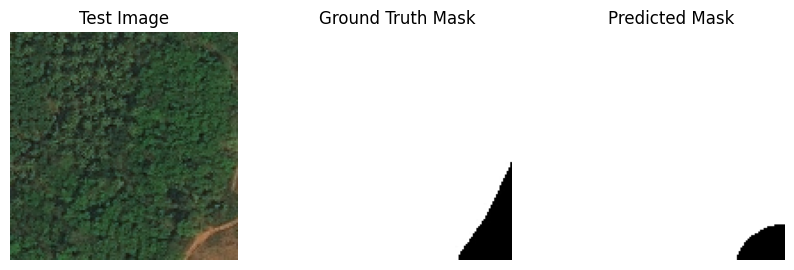

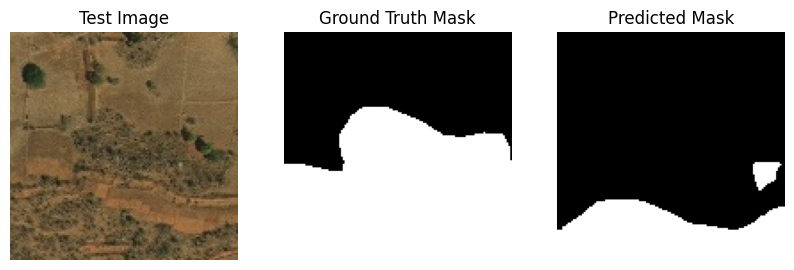

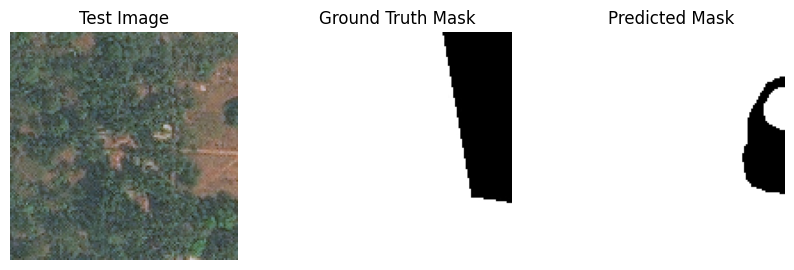

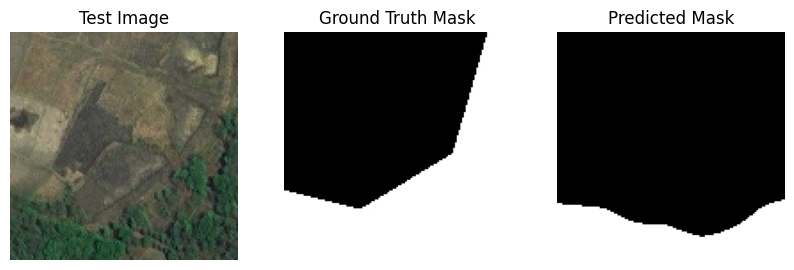

In [30]:
def display_results(x_test, y_test, predicted_masks, index=0):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Test Image")
    plt.imshow(x_test[index])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_test[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_masks[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

for i in range(4):  
    display_results(x_test, y_test, predicted_masks, index=i)